# Machine Learning in Crowd Modelling and Simulation
# Final Project
# Task 4: Extended Dynamic Model Decomposition - Linear System

### Group M:
1. Muhammad Waleed Bin Khalid
2. Qais Hamarneh
3. Yiming Zhang

# Useful Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy
from EDMD import EDMD
from tqdm import tqdm
import dataframe_image as dfi
from Observables import *
from utils import *
%load_ext autoreload
%autoreload 2

## A Linear Example

We work with the linear system 

$$x(n+1)=J x(n) \\
x(n+1)=\left[\begin{array}{cc}
0.9 & -0.1 \\
0.0 & 0.8
\end{array}\right] x(n)$$


In [3]:
J = np.array([[0.9, -0.1],[0, 0.8]])

def linear_system(x):
    x_next = x@J.T
    return x_next

## Actual Eigenvalues


In [4]:
lambda_0, lambda_1 = scipy.linalg.eig(J)[0]
v_0 = scipy.linalg.eig(J)[1][:,0]
v_1 = scipy.linalg.eig(J)[1][:,1]
w_01 = np.linalg.inv(scipy.linalg.eig(J)[1])
w_0 = w_01[0,:]
w_1 = w_01[1,:]
print(f"The matrix has eigenvalues {lambda_0} and {lambda_1}")
print(f"The matrix has eigenvectors {v_0} and {v_1}")
print(f"The matrix has left eigenvectors {w_0} and {w_1}")
w_01

The matrix has eigenvalues (0.9+0j) and (0.8+0j)
The matrix has eigenvectors [1. 0.] and [0.70710678 0.70710678]
The matrix has left eigenvectors [ 1. -1.] and [0.         1.41421356]


array([[ 1.        , -1.        ],
       [ 0.        ,  1.41421356]])

## Koopman Eigenfunction
This makes the Koopman eigenfunction as follows 
$$
\varphi_{n_{1}, n_{2}, \ldots, n_{N}}({x})=\prod_{i=1}^{N}\left({w}_{i}^{*} {x}\right)^{n_{i}}
$$

and the corresponding Koopman eigenvalues are 

$$
\prod_{i=1}^{N} \lambda_{i}^{n_{i}}
$$
where ${w}_{i}$ is the left eigenvector with cooresponding eigen values $\mu_i$


Hence for our linear case we get
$$
\varphi_{i,j} = (\frac{x}{\sqrt{2}}-\frac{y}{\sqrt{2}})^i(y)^j
$$
and
$$
\lambda_{i,j} = (0.9)^i(0.8)^j
$$

We will plot the results now

In [5]:
def linear_koopman_eigenfunction(X, Y, i,j):
    eigenfunc = (X/np.sqrt(2) - Y/np.sqrt(2))**i * (Y)**j
    eigenval = 0.9**i * 0.8**j
    return [eigenval, eigenfunc]

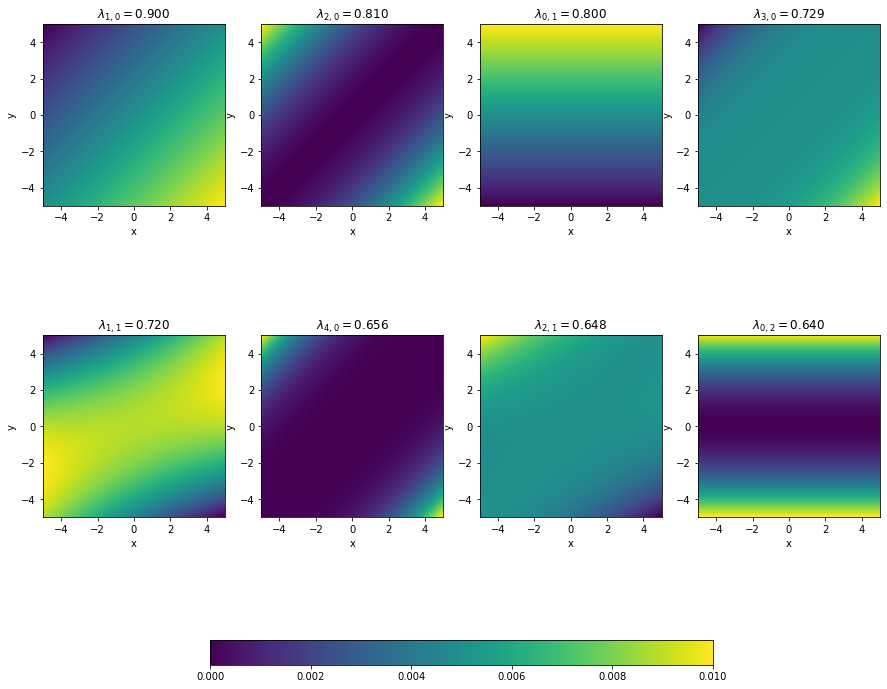

In [6]:
x = np.arange(-5,5,0.1)
y = np.arange(-5,5,0.1)
X, Y = np.meshgrid(x,y)
# Flip array because we want numbering to start from bottom of array instead of the default top from numpy
X = np.flipud(X)
Y = np.flipud(Y)

ij_pair = [(1,0), (2,0), (0,1), (3,0), (1,1), (4,0), (2,1), (0,2)]
fig, axs = plt.subplots(2,4, figsize=(15,15))
axs = axs.flatten()
analytical_eigenval_list = []
analytical_eigenfunc_list = []

for index, ij in enumerate(ij_pair):
    i, j = ij
    analytical_eigenval = linear_koopman_eigenfunction(X, Y, i,j)[0]
    analytical_eigenval_list.append(analytical_eigenval)
    analytical_eigenfunc = linear_koopman_eigenfunction(X, Y, i,j)[1]
    analytical_eigenfunc_normalized = analytical_eigenfunc / np.linalg.norm(analytical_eigenfunc, np.inf)
    analytical_eigenfunc_list.append(analytical_eigenfunc_normalized)
    s = axs[index].imshow(analytical_eigenfunc_normalized,extent=[-5,5,-5,5])
    axs[index].set_title(f"$\lambda_{{{i},{j}}} = ${analytical_eigenval:0.3f}")
    axs[index].set_xlabel('x'); axs[index].set_ylabel('y')
#     axs[index].set_xticks(x); axs[index].set_yticks(y)


fig.colorbar(s, ax=axs[:], shrink=0.6, location='bottom')
# fig.savefig('figures/linear_analytical_eigenfuncs.png')

## Generating Data

In [7]:
initial_conditions = np.array(np.meshgrid(np.linspace(-2, 2, 8), np.linspace(-2, 2, 8))).T.reshape(-1, 2)

In [8]:
x_linear = []
dt = 0.1
t_range = np.arange(0,5,dt)
t_eval = t_range[:-1]
x_sol = pd.DataFrame()
for i, ic in enumerate(initial_conditions):
    ic = ic.reshape(-1, ic.shape[0])
    x_linear = []
    y_linear = []
    x_linear.append(ic)
    time = [0]
    for delta_t in t_range:
        x_linear.append(linear_system(x_linear[-1]))
        y_linear.append(x_linear[-1])
        time.append(time[-1] + dt)
    y_linear.append(linear_system(x_linear[-1]))
    x_linear = np.array(x_linear).squeeze()
    y_linear = np.array(y_linear).squeeze()
    time = np.array(time)
    time = time.reshape(time.shape[0], -1)
    xy_linear = np.concatenate((time, x_linear, y_linear), axis=1)
    if x_sol is None:
        x_df = pd.DataFrame(xy_linear, columns=['time', 'x1', 'x2', 'y1', 'y2'])
        x_df.insert(0,'ID', i)
    else:
        x_df = pd.DataFrame(xy_linear, columns=['time', 'x1', 'x2', 'y1', 'y2'])
        x_df.insert(0,'ID', i)
        x_sol = pd.concat([x_sol, x_df], axis=0)
x_sol

,ID,time,x1,x2,y1,y2
0,0,0.0,-2.000000,-2.000000,-1.600000,-1.600000
1,0,0.1,-1.600000,-1.600000,-1.280000,-1.280000
2,0,0.2,-1.280000,-1.280000,-1.024000,-1.024000
3,0,0.3,-1.024000,-1.024000,-0.819200,-0.819200
4,0,0.4,-0.819200,-0.819200,-0.655360,-0.655360
...,...,...,...,...,...,...
46,63,4.6,0.000070,0.000070,0.000056,0.000056
47,63,4.7,0.000056,0.000056,0.000045,0.000045
48,63,4.8,0.000045,0.000045,0.000036,0.000036
49,63,4.9,0.000036,0.000036,0.000029,0.000029


## Progress of the system - Analytical

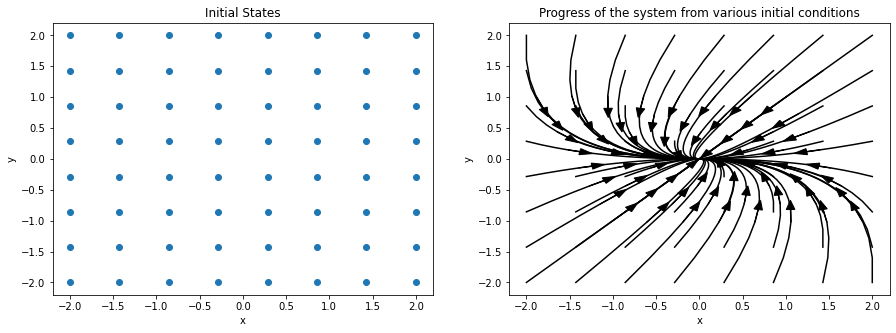

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].scatter(initial_conditions[:,0], initial_conditions[:,1])
plot_data(x_sol, axs[1])
axs[0].set_title('Initial States'); axs[1].set_title('Progress of the system from various initial conditions')
axs[0].set_xlabel('x'); axs[0].set_ylabel('y'); axs[1].set_xlabel('x'); axs[1].set_ylabel('y');
# fig.savefig('figures/linear_system_analytical_progress.png')

## Dictionary: Case - Hermite Polynomials

In this case we use the Hermite dictionary of observables up till the fifth Hermite Polynomial. The hermite polynomials are a class of orthogonal polynomials sequences defined by Pierre-Simon Laplace in 1810. 

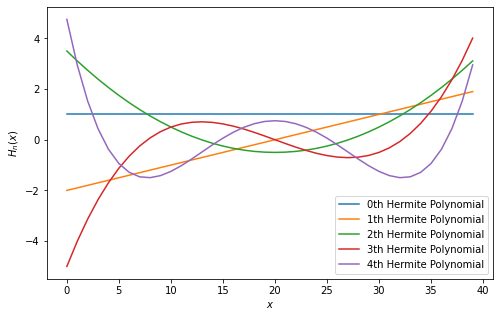

In [10]:
hermite_polys = []
a = np.arange(-2,2, 0.1)
hermite_polys.append(a)
fig, ax = plt.subplots(figsize=(8,5))
for i in range(5):
    hermite_poly = scipy.special.hermite(i, monic=True)
    hermite_polys.append(hermite_poly(a))
    ax.plot(hermite_polys[-1], label=f'{i}th Hermite Polynomial')
ax.set_xlabel('$x$')
ax.set_ylabel('$H_n(x)$')
plt.legend()
# fig.savefig('figures/hermite_polys.png')

In [11]:
hermitian_observables = HermitePairs(5) # We will use the Hermite Pair dictionary as observables
hermite_dict = hermitian_observables.fit(x_sol[['ID', 'time', 'x1', 'x2']])
# dfi.export(hermite_dict.head(),"figures/hermite_dict_obs.png")
hermite_dict

,ID,time,x1,x2,H0(x1)H0(x2),H0(x1)H1(x2),H0(x1)H2(x2),H0(x1)H3(x2),H0(x1)H4(x2),H1(x1)H0(x2),...,H3(x1)H0(x2),H3(x1)H1(x2),H3(x1)H2(x2),H3(x1)H3(x2),H3(x1)H4(x2),H4(x1)H0(x2),H4(x1)H1(x2),H4(x1)H2(x2),H4(x1)H3(x2),H4(x1)H4(x2)
0,0,0.0,-2.000000,-2.000000,1.0,-4.000000,14.000000,-40.000000,76.000000,-4.000000,...,-40.000000,1.600000e+02,-560.000000,1.600000e+03,-3040.000000,76.000000,-304.000000,1064.000000,-3040.000000,5776.000000
1,0,0.1,-1.600000,-1.600000,1.0,-3.200000,8.240000,-13.568000,-6.022400,-3.200000,...,-13.568000,4.341760e+01,-111.800320,1.840906e+02,81.711923,-6.022400,19.271680,-49.624576,81.711923,36.269302
2,0,0.2,-1.280000,-1.280000,1.0,-2.560000,4.553600,-1.417216,-23.693527,-2.560000,...,-1.417216,3.628073e+00,-6.453435,2.008501e+00,33.578846,-23.693527,60.655429,-107.890845,33.578846,561.383224
3,0,0.3,-1.024000,-1.024000,1.0,-2.048000,2.194304,3.698065,-20.739462,-2.048000,...,3.698065,-7.573638e+00,8.114680,1.367569e+01,-76.695887,-20.739462,42.474418,-45.508684,-76.695887,430.125282
4,0,0.4,-0.819200,-0.819200,1.0,-1.638400,0.684355,5.432353,-13.006495,-1.638400,...,5.432353,-8.900368e+00,3.717656,2.951046e+01,-70.655880,-13.006495,21.309842,-8.901054,-70.655880,169.168920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,63,4.6,0.000070,0.000070,1.0,0.000139,-2.000000,-0.000836,12.000000,0.000139,...,-0.000836,-1.165601e-07,0.001673,6.993608e-07,-0.010035,12.000000,0.001673,-23.999999,-0.010035,143.999994
47,63,4.7,0.000056,0.000056,1.0,0.000112,-2.000000,-0.000669,12.000000,0.000112,...,-0.000669,-7.459849e-08,0.001338,4.475909e-07,-0.008028,12.000000,0.001338,-24.000000,-0.008028,143.999996
48,63,4.8,0.000045,0.000045,1.0,0.000089,-2.000000,-0.000535,12.000000,0.000089,...,-0.000535,-4.774303e-08,0.001070,2.864582e-07,-0.006423,12.000000,0.001070,-24.000000,-0.006423,143.999998
49,63,4.9,0.000036,0.000036,1.0,0.000071,-2.000000,-0.000428,12.000000,0.000071,...,-0.000428,-3.055554e-08,0.000856,1.833332e-07,-0.005138,12.000000,0.000856,-24.000000,-0.005138,143.999999



# The EDMD Algorithm

In [12]:
linear_edmd = EDMD(x_sol, 2, hermitian_observables)
linear_edmd.fit()

In [13]:
x = np.arange(-5,5,0.1)
y = np.arange(-5,5,0.1)
X, Y = np.meshgrid(x,y)
# Flip array because we want numbering to start from bottom of array instead of the default top from numpy
X = np.flipud(X)
Y = np.flipud(Y)

## Plotting the first 8 eigenfunctions 
We comparing similarity with analytical eigenfunctions

Note that the 6th eigenfunction is flipped which is in line with the results from the paper

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:26<00:00,  3.32s/it]


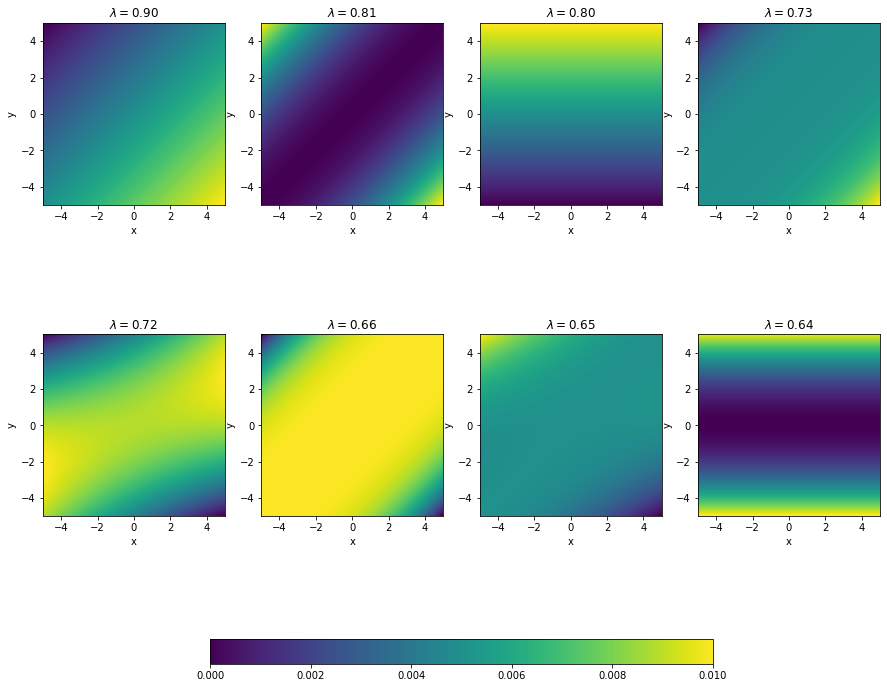

In [15]:
fig, axs = plt.subplots(2,4, figsize=(15,15))
axs = axs.flatten()
eigenfunc_list = []
for index in tqdm(range(len(axs))):
    eigen_func = make_eigenfunction(X,Y, linear_edmd, index+1)
    eigen_func_normalized = eigen_func / np.linalg.norm(eigen_func, np.inf)
    eigenfunc_list.append(eigen_func_normalized)
    # Normalize with infinity Norm
    s = axs[index].imshow(eigen_func_normalized,extent=[-5,5,-5,5])
    axs[index].set_title(f"$\lambda = ${linear_edmd.eigenvalues[index+1].real:0.2f}")
    axs[index].set_xlabel('x'); axs[index].set_ylabel('y')

fig.colorbar(s, ax=axs[:], shrink=0.6, location='bottom')
# fig.savefig('figures/linear_edmd_eigenfunctions.png')

# Difference between eigenvalues and eigenfunctions

In [18]:
print(f"MSE between first 8 eigenvalues compared to analytical solution is {np.sum((linear_edmd.eigenvalues[1:9].real -  np.array(analytical_eigenval_list[:]))**2)/8}")
for i in range(8):
    diff = eigenfunc_list[i] - analytical_eigenfunc_list[i]
    diff = diff.flatten()
    mse = np.sum(diff**2)
    print(f"MSE for {i}th eigenfunction compared to analytical solution {mse}")

MSE between first 8 eigenvalues compared to analytical solution is 2.3511125678289483e-26
MSE for 0th eigenfunction compared to analytical solution 7.391613189545708e-18
MSE for 1th eigenfunction compared to analytical solution 7.69748371134203e-23
MSE for 2th eigenfunction compared to analytical solution 6.554308229154267e-18
MSE for 3th eigenfunction compared to analytical solution 6.420870771953517e-20
MSE for 4th eigenfunction compared to analytical solution 6.320938578979514e-23
MSE for 5th eigenfunction compared to analytical solution 2.3350922391837754
MSE for 6th eigenfunction compared to analytical solution 2.3108595830865163e-19
MSE for 7th eigenfunction compared to analytical solution 4.253910508301399e-21


## Matrix B

Matrix B can be selected such that the original state is recovered from the observables. In our case the observables are as below

$$
\begin{aligned}
\mathcal{D}=&\left\{\psi_{0}, \psi_{1}, \psi_{2}, \ldots\right\} \\
&\left\{H_{0}(x) H_{0}(y), H_{1}(x) H_{0}(y), H_{2}(x) H_{0}(y), H_{3}(x) H_{0}(y), H_{4}(x) H_{0}(y),\right.\\
& H_{0}(x) H_{1}(y), H_{1}(x) H_{1}(y), H_{2}(x) H_{1}(y), H_{3}(x) H_{1}(y), H_{4}(x) H_{1}(y), \\
& H_{0}(x) H_{2}(y), H_{1}(x) H_{2}(y), H_{2}(x) H_{2}(y), H_{3}(x) H_{2}(y), H_{4}(x) H_{2}(y), \\
& H_{0}(x) H_{3}(y), H_{1}(x) H_{3}(y), H_{2}(x) H_{3}(y), H_{3}(x) H_{3}(y), H_{4}(x) H_{3}(y), \\
&\left.H_{0}(x) H_{4}(y), H_{1}(x) H_{4}(y), H_{2}(x) H_{4}(y), H_{3}(x) H_{4}(y), H_{4}(x) H_{4}(y)\right\},
\end{aligned}
$$

So we see to recover x we need the second element and to recover y we need the sixth element. Hence B becomes:

$$
{B}=\left[\begin{array}{lll}
0 & 0 \\
1 & 0 \\
0 & 0 \\
0 & 0 \\
0 & 0 \\
0 & 1 \\
0 & 0 \\
\vdots & \vdots
\end{array}\right]
$$

In [19]:
B = np.zeros((25, 2))
B[5,0] = 1/2
B[1,1] = 1/2

However since we do not want to supply B each time we use the least squares method to calculate B. This is because

$$
X = \psi(X) B
$$
$$
B = \min _{B}\left\|X -\psi(X) B\right\|^{2}
$$

This can be seen in the method `EDMD.estimate_B`

## Eigen Modes and Predictions

In [44]:
initial_values = pd.DataFrame(initial_conditions, columns=['x1', 'x2'])
initial_values.insert(0, 'ID', range(len(initial_values)))
initial_values.insert(1, 'time', 0)
initial_values
x_predict_edmd = linear_edmd.predict(initial_values, t_range=t_range)
x_predict_edmd

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [01:28<00:00,  1.38s/it]


,ID,time,x1,x2
0,0.0,0.0,-2.000000,-2.000000
0,0.0,1.0,-1.600000,-1.600000
0,0.0,2.0,-1.280000,-1.280000
0,0.0,3.0,-1.024000,-1.024000
0,0.0,4.0,-0.819200,-0.819200
...,...,...,...,...
0,63.0,46.0,0.000070,0.000070
0,63.0,47.0,0.000056,0.000056
0,63.0,48.0,0.000045,0.000045
0,63.0,49.0,0.000036,0.000036


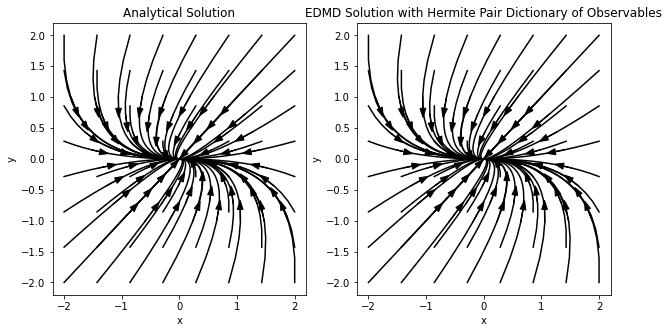

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
plot_data(x_predict_edmd, axs[1])
plot_data(x_sol, axs[0])
axs[0].set_title('Analytical Solution')
axs[0].set_xlabel('x'); axs[0].set_ylabel('y'); 
axs[1].set_title('EDMD Solution with Hermite Pair Dictionary of Observables')
axs[1].set_xlabel('x'); axs[1].set_ylabel('y'); 
# fig.savefig('figures/linear_edmd_solution.png')

In [48]:
x_actual = x_sol[x_sol['ID'] == 3].iloc[:,:4]
initial_values = x_actual.iloc[0:1,:]
t_range = np.arange(0,51)
x_predict = linear_edmd.predict(initial_values, t_range=t_range)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]


MSE for test trajectory is 3.38976411463474e-24


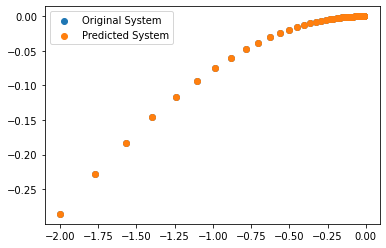

In [49]:
fig, axs = plt.subplots(1,1, sharex=True, sharey=True)
axs.scatter(x_actual.iloc[:,2].to_numpy().real, x_actual.iloc[:,3].to_numpy().real, label='Original System')
axs.scatter(x_predict.iloc[:,2].to_numpy().real, x_predict.iloc[:,3].to_numpy(), label='Predicted System')
plt.legend()

mse = mse_calc(x_actual.iloc[:,2:].to_numpy(), x_predict.iloc[:,2:].to_numpy())
print(f"MSE for test trajectory is {mse}")

In [50]:
print(f"MSE for all trajectories combined is {mse_all_traj(x_sol, x_predict_edmd)}")

MSE for all trajectories combined is 4.788575852390346e-24


## Lets try the same with the identity dictionary

We now wish to do the same procedure but with the identity dictionary of observables. This is in effect the DMD method as discussed before. Since we have a linear time invariant system at our hands, we can expect exact values.

In [52]:
identity_observables = Identity() # We will use the Hermite Pair dictionary as observables
identity_observables.fit(x_sol.iloc[:,0:3])

,ID,time,x1,x1
0,0,0.0,-2.000000,-2.000000
1,0,0.1,-1.600000,-1.600000
2,0,0.2,-1.280000,-1.280000
3,0,0.3,-1.024000,-1.024000
4,0,0.4,-0.819200,-0.819200
...,...,...,...,...
46,63,4.6,0.000070,0.000070
47,63,4.7,0.000056,0.000056
48,63,4.8,0.000045,0.000045
49,63,4.9,0.000036,0.000036


## A note on the eigenvalues/vectors
We extract the eigenvalues and vectors of the Koopman matrix from this approach and find that they are exactly the same as the analytical solution. This is because the dictionary does not have non-linear terms polluting its space which for a linear time invariant system is excellent (but not good for non-linear systems.)

In [53]:
linear_dmd = EDMD(x_sol, 2, identity_observables)
linear_dmd.fit()
print(f"Right eigenvectors form EDMD with identity dictionary {linear_dmd.eigenvectors_right[:,0]}")
print(f"Right eigenvectors form EDMD with identity dictionary {linear_dmd.eigenvectors_right[:,1]}")
print(f"Left eigenvectors form EDMD with identity dictionary {linear_dmd.eigenvectors_left_conj[0,:]}")
print(f"Left eigenvectors form EDMD with identity dictionary {linear_dmd.eigenvectors_left_conj[1,:]}")
print(f"Eigenvalues form EDMD with identity dictionary {linear_dmd.eigenvalues}")

Right eigenvectors form EDMD with identity dictionary [ 0.70710678 -0.70710678]
Right eigenvectors form EDMD with identity dictionary [0. 1.]
Left eigenvectors form EDMD with identity dictionary [1.41421356 0.        ]
Left eigenvectors form EDMD with identity dictionary [1. 1.]
Eigenvalues form EDMD with identity dictionary [0.9 0.8]


## Predicting with DMD

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]

MSE for test trajectory is 1.711823918211892e-30


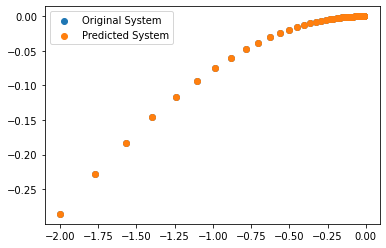

In [54]:
x_actual = x_sol[x_sol['ID'] == 3].iloc[:,:4]
initial_values = x_actual.iloc[0:1,0:4]
x_predict = linear_dmd.predict(initial_values, t_range=t_range)
fig, axs = plt.subplots(1,1, sharex=True, sharey=True)
axs.scatter(x_actual.iloc[:,2].to_numpy().real, x_actual.iloc[:,3].to_numpy().real, label='Original System')
axs.scatter(x_predict.iloc[:,2].to_numpy().real, x_predict.iloc[:,3].to_numpy(), label='Predicted System')
plt.legend()

mse = mse_calc(x_actual.iloc[:,2:].to_numpy(), x_predict.iloc[:,2:].to_numpy())
print(f"MSE for test trajectory is {mse}")

In [55]:
initial_values = pd.DataFrame(initial_conditions, columns=['x1', 'x2'])
initial_values.insert(0, 'ID', range(len(initial_values)))
initial_values.insert(1, 'time', 0)

x_predict_dmd = linear_dmd.predict(initial_values, t_range=t_range)
x_predict_dmd

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:15<00:00,  4.09it/s]


,ID,time,x1,x2
0,0.0,0.0,-2.000000,-2.000000
0,0.0,1.0,-1.600000,-1.600000
0,0.0,2.0,-1.280000,-1.280000
0,0.0,3.0,-1.024000,-1.024000
0,0.0,4.0,-0.819200,-0.819200
...,...,...,...,...
0,63.0,46.0,0.000070,0.000070
0,63.0,47.0,0.000056,0.000056
0,63.0,48.0,0.000045,0.000045
0,63.0,49.0,0.000036,0.000036


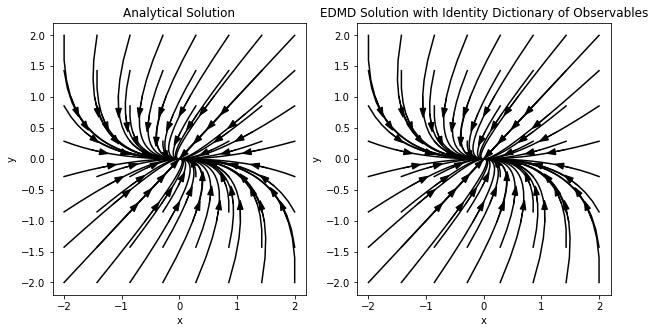

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
plot_data(x_sol, axs[0])
plot_data(x_predict_dmd, axs[1])
axs[0].set_title('Analytical Solution')
axs[0].set_xlabel('x'); axs[0].set_ylabel('y'); 
axs[1].set_title('EDMD Solution with Identity Dictionary of Observables')
axs[1].set_xlabel('x'); axs[1].set_ylabel('y'); 
# fig.savefig('figures/linear_dmd_solution.png')

In [57]:
print(f"MSE for all trajectories combined is {mse_all_traj(x_sol, x_predict_dmd)}")

MSE for all trajectories combined is 9.913122623410843e-31
